In [1]:
from fastai.text import *
from fastai.metrics import *

/home/shorta1/.conda/envs/fastai-203/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729128610/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from transformers import RobertaTokenizer
roberta_tok = RobertaTokenizer.from_pretrained("roberta-large")

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]


In [5]:
fastai_tokenizer = Tokenizer(tok_func = 
FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), pre_rules=[], 
post_rules=[])

In [6]:
path = Path()
roberta_tok.save_vocabulary(path) 
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

In [7]:
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)
         
class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)
        
def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]


In [8]:
class RobertaDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)


In [9]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

In [10]:
df = pd.read_csv("cleaned_train.csv")
feat_cols = "text"
label_cols = "target"

In [11]:
df.head()

,Unnamed: 0,id,text,target
0,0,1,our deeds are the reason of this earthquake ma...,1
1,1,4,forest fire near la ronge sask canada,1
2,2,5,all residents asked to 'shelter in place' are ...,1
3,3,6,13000 people receive wildfires evacuation orde...,1
4,4,7,just got sent this photo from ruby alaska as s...,1


In [12]:
df.dropna()
df.isna().any()

Unnamed: 0    False
id            False
text          False
target        False
dtype: bool

In [13]:
test_df = pd.read_csv('test.csv')
feat_cols = "text"
test_df.dropna()
test_df.isna().any()
test_df = test_df.fillna("")

In [14]:
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=2019) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols, processor=processor)) \
    .databunch(bs=4, pad_first=False, pad_idx=0)

In [15]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits

In [16]:
roberta_model = CustomRobertatModel()

In [17]:
learn = Learner(data, roberta_model, metrics=[accuracy])

In [18]:
learn.model.roberta.train() # set roberta into train mode

learn.fit_one_cycle(3,max_lr = 1e-6, callbacks=callbacks.SaveModelCallback(learn, 
                                                                   every='epoch', monitor='accuracy', name='first_iteration'))

epoch,train_loss,valid_loss,accuracy,time
0,0.607288,0.591404,0.798949,17:36
1,0.371999,0.390414,0.837057,16:38
2,0.396793,0.388542,0.837057,17:10


In [19]:
learn.save('first_iteration')

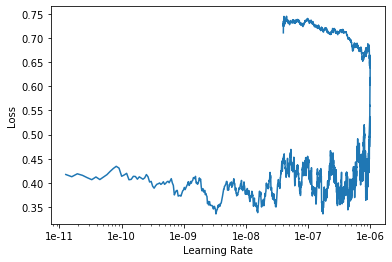

In [20]:
learn.recorder.plot()

In [21]:
#learn.fit_one_cycle(10,max_lr = 1e-9, callbacks=callbacks.SaveModelCallback(learn, 
                #                                                   every='epoch', monitor='accuracy', name='second_iteration'))

In [22]:
#learn.save('second_iteration')

In [23]:
#learn.recorder.plot()

In [24]:
#learn.fit_one_cycle(5,max_lr = 1e-6, callbacks=callbacks.SaveModelCallback(learn, 
                                      #                             every='epoch', monitor='accuracy', name='third_iteration'))

In [25]:
learn.load('first_iteration')

Learner(data=RobertaDataBunch;

Train: LabelList (6091 items)
x: RobertaTextList
<s> our Ġdeeds Ġare Ġthe Ġreason Ġof Ġthis Ġearthquake Ġmay Ġall ah Ġforgive Ġus Ġall </s>,<s> forest Ġfire Ġnear Ġla Ġr onge Ġs ask Ġcan ada </s>,<s> all Ġresidents Ġasked Ġto Ġ' s hel ter Ġin Ġplace ' Ġare Ġbeing Ġnotified Ġby Ġofficers Ġno Ġother Ġevacuation Ġor Ġshelter Ġin Ġplace Ġorders Ġare Ġexpected </s>,<s> 13 000 Ġpeople Ġreceive Ġwildfires Ġevacuation Ġorders Ġin Ġcal if ornia </s>,<s> just Ġgot Ġsent Ġthis Ġphoto Ġfrom Ġruby Ġal aska Ġas Ġsmoke Ġfrom Ġwildfires Ġp ours Ġinto Ġa Ġschool </s>
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (1522 items)
x: RobertaTextList
<s> ty ph oon Ġs oud el or Ġtaking Ġdead Ġaim Ġat Ġt ai wan Ġhttp :// t co / bh su x v q 6 n f </s>,<s> ended Ġtoday 's Ġstaff Ġmeeting Ġwith Ġthe Ġteacher Ġversion Ġof Ġ' i Ġwill Ġsurvive ' Ġto ot rue Ġhttp :// t co / mc wd 37 io f 9 </s>,<s> s ustain ability Ġtask Ġforce Ġpresents Ġlevy Ġto Ġfund Ġemergency Ġservices Ġ- Ġw

#### Predictions

In [26]:
import numpy as np
import pandas as pd
pd.set_option('display.max_row', 10000)
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [27]:
def get_preds_as_nparray(ds_type) -> np.ndarray:

    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values
# For Valid
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [28]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [29]:
test_preds

(array([[0.08296 , 0.91704 ],
        [0.040627, 0.959373],
        [0.065951, 0.934049],
        [0.069728, 0.930272],
        ...,
        [0.066987, 0.933013],
        [0.044487, 0.955513],
        [0.211782, 0.788218],
        [0.091956, 0.908044]], dtype=float32),
 array([1, 1, 1, 1, ..., 1, 1, 1, 1]))

#### Probabilities

In [30]:
all_probs = [[max(a,b) for a,b in test_preds[0]]]
print(type(all_probs))
print(all_probs)

<class 'list'>
[[0.91703963, 0.9593728, 0.9340495, 0.93027204, 0.9543823, 0.9024725, 0.84596086, 0.83707315, 0.9001482, 0.8884328, 0.8981431, 0.91448975, 0.9280154, 0.80517465, 0.9098216, 0.93446416, 0.8652832, 0.68708944, 0.8082972, 0.9375708, 0.8025307, 0.91583157, 0.9018186, 0.87357485, 0.8890181, 0.77164227, 0.8851954, 0.7286894, 0.8762242, 0.9351939, 0.91438216, 0.8935042, 0.8279146, 0.83732224, 0.9310433, 0.8805475, 0.8608754, 0.78516406, 0.90906703, 0.9217089, 0.948651, 0.9071088, 0.70469123, 0.67522895, 0.842874, 0.81105506, 0.8505525, 0.9086661, 0.95136225, 0.8820312, 0.9366758, 0.866833, 0.78902954, 0.88494885, 0.72764164, 0.8874377, 0.84488225, 0.8468281, 0.8901591, 0.5036559, 0.8494089, 0.6789421, 0.8581314, 0.86968774, 0.9427572, 0.96320444, 0.7083382, 0.9651629, 0.9579688, 0.92819613, 0.8280882, 0.79778636, 0.95016825, 0.96127087, 0.9465499, 0.9610049, 0.90672755, 0.7824775, 0.8257021, 0.8913085, 0.8505973, 0.67199737, 0.87285674, 0.84231097, 0.9527634, 0.5957574, 0.52717

In [31]:
prob_df = pd.DataFrame(all_probs)
prob_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262
0,0.91704,0.959373,0.934049,0.930272,0.954382,0.902472,0.845961,0.837073,0.900148,0.888433,...,0.926713,0.903181,0.919801,0.544078,0.951399,0.860608,0.933013,0.955513,0.788218,0.908044


In [32]:
prob_df = pd.melt(prob_df)

In [33]:
prob_df = prob_df['value']

In [34]:
prob_df.head()

0    0.917040
1    0.959373
2    0.934049
3    0.930272
4    0.954382
Name: value, dtype: float64

In [35]:
test_df['probability'] = prob_df
test_df.head()

,id,keyword,location,text,probability
0,0,,,Just happened a terrible car crash,0.917040
1,2,,,"Heard about #earthquake is different cities, s...",0.959373
2,3,,,"there is a forest fire at spot pond, geese are...",0.934049
3,9,,,Apocalypse lighting. #Spokane #wildfires,0.930272
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,0.954382


#### Targets

In [36]:
all_targets = test_preds[1]
print(type(all_targets))
print(all_targets)

<class 'numpy.ndarray'>
[1 1 1 1 ... 1 1 1 1]


In [37]:
test_df['target'] = all_targets
test_df.head(20)

,id,keyword,location,text,probability,target
0,0,,,Just happened a terrible car crash,0.917040,1
1,2,,,"Heard about #earthquake is different cities, s...",0.959373,1
2,3,,,"there is a forest fire at spot pond, geese are...",0.934049,1
3,9,,,Apocalypse lighting. #Spokane #wildfires,0.930272,1
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,0.954382,1
5,12,,,We're shaking...It's an earthquake,0.902472,1
6,21,,,They'd probably still show more life than Arse...,0.845961,0
7,22,,,Hey! How are you?,0.837073,0
8,27,,,What a nice hat?,0.900148,0
9,29,,,Fuck off!,0.888433,0


In [38]:
test_df 

,id,keyword,location,text,probability,target
0,0,,,Just happened a terrible car crash,0.917040,1
1,2,,,"Heard about #earthquake is different cities, s...",0.959373,1
2,3,,,"there is a forest fire at spot pond, geese are...",0.934049,1
3,9,,,Apocalypse lighting. #Spokane #wildfires,0.930272,1
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,0.954382,1
5,12,,,We're shaking...It's an earthquake,0.902472,1
6,21,,,They'd probably still show more life than Arse...,0.845961,0
7,22,,,Hey! How are you?,0.837073,0
8,27,,,What a nice hat?,0.900148,0
9,29,,,Fuck off!,0.888433,0


In [45]:
flagged = test_df[test_df['probability'] <= .6]
flagged

,id,keyword,location,text,probability,target
59,192,aftershock,Runcorn,Aftershock https://t.co/38Nhq9moEf,0.503656,0
85,292,ambulance,"West Chester, PA",Why should a helicopter ambulance ride to tran...,0.595757,0
86,295,ambulance,"Chorley, Lancashire, UK",so privileged and proud to wear this uniform.?...,0.527177,1
104,351,annihilation,,Allied Plans for the Annihilation of the Germa...,0.506448,1
106,359,annihilation,Colorado,U.S National Park Services Tonto National Fore...,0.512232,1
109,367,annihilation,"Plovdiv, Bulgaria",U.S National Park Services Tonto National Fore...,0.513000,1
110,369,annihilation,California,U.S National Park Services Tonto National Fore...,0.522500,1
114,377,annihilation,U.S.A.,U.S National Park Services Tonto National Fore...,0.503255,1
115,378,annihilation,Arizona,U.S National Park Services Tonto National Fore...,0.506031,0
117,382,annihilation,Chicago,U.S National Park Services Tonto National Fore...,0.500018,1


In [48]:
test_df['flag'] = np.where(test_df.probability <= .6, 1, 0)

In [49]:
test_df

,id,keyword,location,text,probability,target,flag
0,0,,,Just happened a terrible car crash,0.917040,1,0
1,2,,,"Heard about #earthquake is different cities, s...",0.959373,1,0
2,3,,,"there is a forest fire at spot pond, geese are...",0.934049,1,0
3,9,,,Apocalypse lighting. #Spokane #wildfires,0.930272,1,0
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,0.954382,1,0
5,12,,,We're shaking...It's an earthquake,0.902472,1,0
6,21,,,They'd probably still show more life than Arse...,0.845961,0,0
7,22,,,Hey! How are you?,0.837073,0,0
8,27,,,What a nice hat?,0.900148,0,0
9,29,,,Fuck off!,0.888433,0,0


0 - fake
1 - real

In [ ]:
#test_df['target'] = test_df['target'].map({0:'fake', 1:'real'}) 

In [50]:
test_df.to_csv("predictions_1.csv", index=False)